# 循环神经网络

n-Gram模型
- 单词$x_t$在时间步$t$的条件概率仅取决于前面$n-1$个单词
- 对于时间步$t-(n-1)$之前的单词，如果想将其可能产生的影响合并到$x_t$上，需要增加$n$
- 则模型参数的数量会随之呈指数增长，因为词表$N$需要存储$|N|^n$个数字
- 与其将$P(x_t \mid x_{t-1}, \ldots, x_{t-n+1})$模型化，不如使用隐藏变量模型：
$$P(x_t \mid x_{t-1}, \ldots, x_1) \approx P(x_t \mid h_{t-1}),$$

循环神经网络
- 具有隐状态的神经网络

潜变量自回归模型
- 使用潜变量$h_t$总结过去信息
  - $p(h_t \mid h_{t-1},x_{t-1})$
  - $p(x_t \mid h_t,x_{t-1})$

循环神经网络
- 最简单的RNN，是通过$W_{hh}$来存时序信息
- 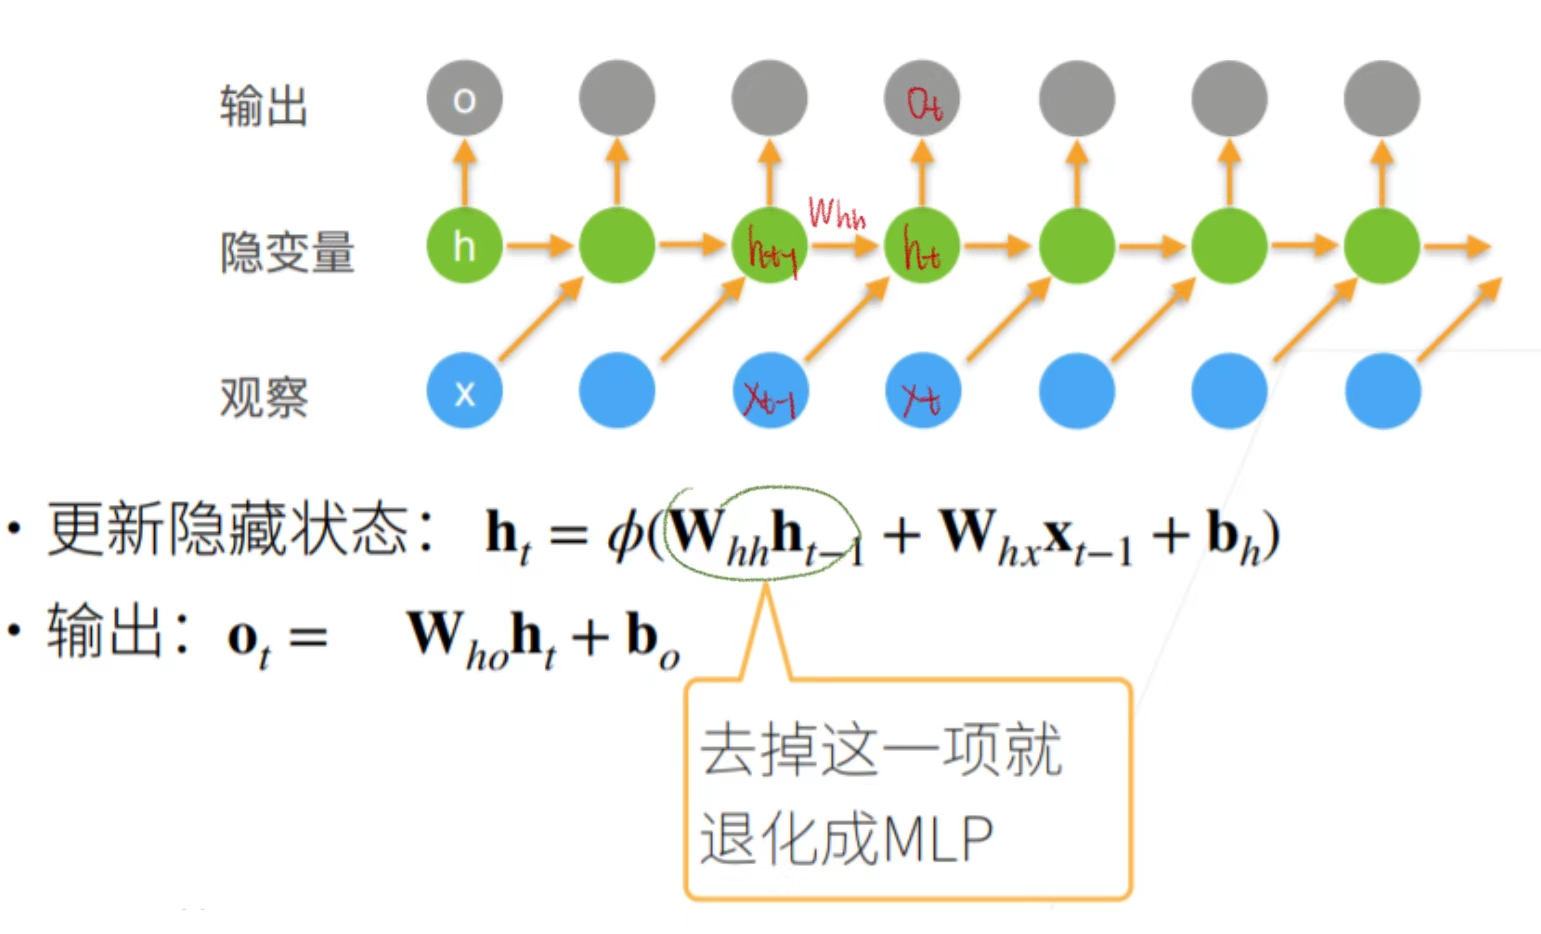

困惑度（preplexity）——量化预言模型预测能力的指标
- 衡量一个预言模型的好坏可以用平均交叉熵
$$\pi = \frac{1}{n} \sum_{i=1}^{n} - \log p( x_t \mid x_{t-1}, \dots) $$
$p$是语言模型的预测概率，$x_t$是真实词
- 历史原因NLP使用困惑度$exp(\pi)$来衡量，是平均每次可能选项
  - 1表示完美，无穷大是最差情况

梯度裁剪
- 迭代中计算这$T$个时间步上的梯度，在反向传播过程中产生长度为$O(T)$的矩阵乘法链，导致数值不稳定
- 梯度裁剪能有效预防梯度爆炸
  - 如果梯度长度超过$\theta$，那么投影回长度$\theta$
  $$\mathbf{g} ← min(1, \frac{\theta}{||g||})\mathbf{g}$$

更多的应用RNNs
- one-to-one：就是一个MLP
- 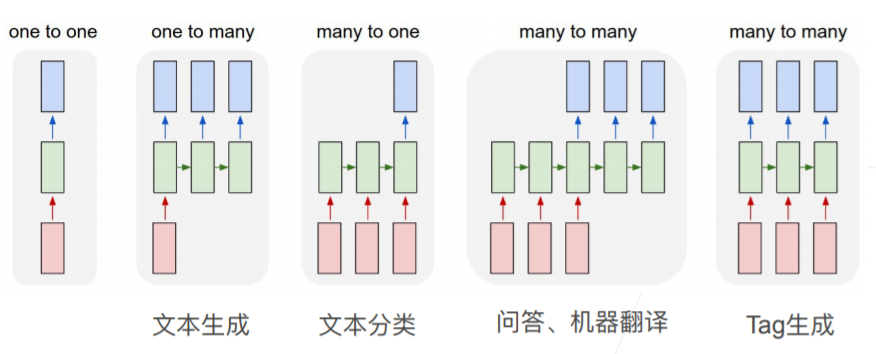

总结
- 循环神经网络的输出取决于当下输入和前一时间的隐变量
- 应用到预言模型中时，循环神经网络根据当前词预测下一次时刻词
- 通常使用困惑度来衡量预言模型的好坏

## 从0开始实现
尽量使用GPU

In [ ]:
!pip install d2l

In [ ]:
import math
import torch
import re
import random

from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [ ]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt', '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
  with open(d2l.download('time_machine'), 'r') as f:
    lines = f.readlines()
  return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]


def load_corpus_time_machine(max_tokens=-1):
  lines = read_time_machine()
  tokens = d2l.tokenize(lines, 'char')
  vocab = d2l.Vocab(tokens)
  corpus = [vocab[token] for line in tokens for token in line]
  if max_tokens > 0:
    corpus = corpus[:max_tokens]
  return corpus, vocab


def seq_data_iter_random(corpus, batch_size, num_steps):
  corpus = corpus[random.randint(0, num_steps - 1):]  # 随机偏移位置
  num_subseqs = (len(corpus) - 1) // num_steps  # 子序列的数目
  # 子序列起始位置的索引列表
  initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
  # 打乱
  random.shuffle(initial_indices)
  # 提取从pos开始的子序列
  def data(pos):
    return corpus[pos: pos + num_steps]
  num_batches = num_subseqs // batch_size
  for i in range(0, batch_size * num_batches, batch_size):
    inital_indices_per_batch = initial_indices[i: i + batch_size]  # 已经打乱过了
    X = [data(j) for j in inital_indices_per_batch]
    # Y是与X对齐的目标子序列，向后偏移一个时间步（预测下一个字符）
    Y = [data(j + 1) for j in inital_indices_per_batch]
    yield torch.tensor(X), torch.tensor(Y)


def seq_data_iter_sequential(corpus, batch_size, num_steps):
  offset = random.randint(0, num_steps)
  # 是batch_size的整数倍
  num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
  # 截取有效的输入序列和目标序列
  Xs = torch.tensor(corpus[offset: offset + num_tokens])
  Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
  # 重塑为批量形式
  Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
  num_batches = Xs.shape[1] // num_steps
  for i in range(0, num_steps * num_batches, num_steps):  # 序列长度不够，则要分割
    X = Xs[:, i: i + num_steps]
    Y = Ys[:, i: i + num_steps]
    yield X, Y


class seqDataLoader:
  def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
    if use_random_iter:
      self.data_iter_fn = seq_data_iter_random
    else:
      self.data_iter_fn = seq_data_iter_sequential
    self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
    self.batch_size, self.num_steps = batch_size, num_steps

  def __iter__(self):
    return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
  data_iter = seqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
  return data_iter, data_iter.vocab

In [ ]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

### 独热编码

通常将每个词元表示为更具表现力的特征向量
- 最简单的表示成为**独热编码（one-hot encoding）**

**注意（重要！！！）**：
- 当对一个对象**调用`len()`**时，实际上是调用了该对象的`__len__()`方法
  - 如果类中定义了`__len__()`方法，`len()`就会使用这个方法返回对象的长度
- 调用`__getitem__`方法的标准方式是使用**方括号访问对象的元素**
  - 使用**`obj[key]`**的形式
- 调用`__call__`方法，使用**小括号访问**
  - 使用**`obj(key)`**的形式
- 调用`__iter__`方法
  - 隐式：**通过`for`循环**隐式调用`__iter__`
  - 显式：通过**`iter(obj)`显式**调用

- `F.one_hot(input, num_classes=None)`将输入的**整数张量**转换为**one-hot编码**
  - 返回一个新的张量，形状为`input.shape + (num_classes,)`，其中每个整数被编码为一个热码，
  - `num_classes`表示生成one-hot编码向量的类别总数
    - 如果未提供，默认使用`input`中的最大值加1作为类别总数

In [ ]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

每次采样的小批量数据形状是**二维张量`(batch_size, time_steps时间步)`**
- one-hot函数将这样一个小批量数据转换为**三维张量**，最后一维等于**词表大小**（len(vocab）
- 但是会转换为**（时间步，批量大小，词表大小）**
  - 方便通过最外层的维度，一步步更新小批量数据的隐状态（同一时间步的是连续的）

In [ ]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, len(vocab)).shape

torch.Size([5, 2, 28])

### 初始化模型参数

初始化循环神经网络模型的参数
- 隐藏单元数`num_hiddens`是一个可调的超参数
- 训练语言模型时，输入和输出都来自相同的词表
  - 故具有相同的维度，即词表的大小

- `.requires_grad_(requires_grad=True)`
  - 直接修改张量**本身**的属性，不会返回新的张量

In [ ]:
def get_params(vocab_size, num_hiddens, device):
  num_inputs = num_outputs = vocab_size

  def normal(shape):
    return torch.randn(size=shape, device=device) * 0.01

  # 隐藏层参数
  W_xh = normal((num_inputs, num_hiddens))
  W_hh = normal((num_hiddens, num_hiddens))
  b_h = torch.zeros(num_hiddens, device=device)
  # 输出层参数
  W_hq = normal((num_hiddens, num_outputs))
  b_q = torch.zeros(num_outputs, device=device)
  # 附加梯度
  params = [W_xh, W_hh, b_h, W_hq, b_q]
  for param in params:
    param.requires_grad = True
  return params

### 循环神经网络模型

**首先在初始化时返回隐藏状态`H`**
- **形状为`(batch_size, num_hiddens)`**
- 后面会遇到隐状态包含多个变量的情况，所以使用**元组**会更容易处理

In [ ]:
def init_rnn_state(batch_size, num_hiddens, device):
  # 返回一个元组
  return (torch.zeros((batch_size, num_hiddens), device=device),)

`rnn`函数定义了如何**在一个时间步内计算隐状态和输出**
- 以便逐时间步更新小批量数据的隐状态`H`
- 使用`tanh`函数作为激活函数
- `outputs`在**`dim=0`进行`cat`**
  - 看作是一个**`batch_size * time_steps`**个样本

形状说明：
- `input`的形状是`(time_steps, batch_size, voacb_size)`
- `Y`的形状`(batch_size, voacb_size)`
- `torch.cat(outputs, dim=0)`的形状`(batch_size * time_steps, vocab_size)`

In [ ]:
def rnn(inputs, state, params):
  W_xh, W_hh, b_h, W_hq, b_q = params
  H, = state
  outputs = []
  # X的形状：（批量大小，词表大小），根据时间步依次选取
  for X in inputs:
    H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
    Y = torch.mm(H, W_hq) + b_q
    outputs.append(Y)
  return torch.cat(outputs, dim=0), (H,)  # 返回的一个tensor的第一维是 batch_size * 时间步

**创建一个类来包装这些函数**

- **`__call__`**使对象可以像函数一样被调用
  - 在类中定义了`__call__`方法，则该类的对象可以通过**`obj()`的形式**调用
  - 在深度学习框架中，`__call__`常用于封装模块的前向传播逻辑
  ```
  def __call__(self, x):
    return self.forward(x)
  ```

- `__call__`中一定要对`X`进行转置！将时间步放到最前


In [ ]:
class RNNModelScratch:
  def __init__(
    self, vocab_size, num_hiddens, device,
    get_params, init_state, forward_fn
  ):
    self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
    self.params = get_params(vocab_size, num_hiddens, device)
    self.init_state, self.forward_fn = init_state, forward_fn

  def __call__(self, X, state):
    X = F.one_hot(X.T, self.vocab_size).type(torch.float32)  # 将时间放在第一维
    return self.forward_fn(X, state, self.params)

  def begin_state(self, batch_size, device):
    return self.init_state(batch_size, self.num_hiddens, device)

**检查是否具有正确的形状**
- `Y`的shape是**`(batch_size * time_step, vocab_size)`**
- 状态`H`的shape**`(batch_size, num_hiddens)`**

- *位置参数不能出现在关键字参数之后*

In [ ]:
num_hiddens = 512
net = RNNModelScratch(
  len(vocab), num_hiddens, d2l.try_gpu(),
  get_params, init_rnn_state, rnn
)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

### 预测

**首先定义预测函数 来生成`prefix`之后的新字符**
- **预热期（warm-up）**：在循环遍历`prefix`中的开始字符时，不断将隐状态传递到下一个时间步，但不生成任何输出
  - 在此期间，模型会自我更新，但不会进行预测
- 预热期结束后，隐状态的值通常比初始值更适合预测，从而预测字符并输出

- `batch_size=1`对**一个字符串**做预测


- `separator.join(iterable)`将一个可迭代对象的元素连接成字符串的**字符串方法**
  - `separator`一个字符串，表示连接符
  - `iterabel`一个可迭代对象，元素需要时字符串型

In [ ]:
def predict_ch8(prefix, num_preds, net, vocab, device):
  state = net.begin_state(batch_size=1, device=device)
  # 第一个对应的下标（字符串对应的下标）
  outputs = [vocab[prefix[0]]]
  # 得到输入（上次输出的最后一个词）
  get_input = lambda: torch.tensor(outputs[-1], device=device).reshape(1, 1)
  # 预热期
  for y in prefix[1:]:
    _, state = net(get_input(), state)  # 主要是将信息放入state中
    outputs.append(vocab[y])  # 不会累计误差
  for _ in range(num_preds):
    y, state = net(get_input(), state)
    outputs.append(int(y.argmax(dim=1).reshape(1)))
  return ''.join([vocab.idx_to_token[i] for i in outputs])

**测试`predict_ch8`函数**
- 还没有训练网络，会生成荒谬的预测结果

In [ ]:
predict_ch8('time traveller', 10, net, vocab, d2l.try_gpu())

'time travellerjugjum<unk><unk>qv'

### 梯度剪裁
提供了一个**快速修复梯度爆炸的方法**，虽然不能完全解决问题，但是是众多有效的技术之一
$$\mathbf{g} \leftarrow min(1, \frac{\theta}{||\mathbf{g}||}) \mathbf{g}$$

In [ ]:
def grad_clippin(net, theta):
  # 拿到的是所有层的可训练的参数
  if isinstance(net, nn.Module):
    params = [p for p in net.parameters() if p.requires_grad]
  else:
    params = net.params
  # 将所有层的参数拼在一起，对这个大的向量取模
  norm = torch.sqrt(sum(torch.sum(p.grad ** 2) for p in params))
  if norm > theta:
    for param in params:
      param.grad[:] *= theta / norm

### 训练

先**定义一个在一个迭代周期内的训练模型**
- 序列数据的不同采样方法（随机采样和顺序分区）将导致隐状态初始化的差异
- 在更新模型参数之前裁剪梯度
- 使用困惑度来评价模型（确保不同长度的序列具有可比性）

使用顺序分区：**只在每个迭代周期的开始位置初始化隐状态**
- 下一个批量数据中的第$i$ 子序列样本与当前第$i$哥子序列样本相邻
  - 故当前小批量数据最高一个样本的隐状态将用于初始化下一个小批量数据第一个样本的隐状态
  - 这样存储在隐状态中的序列的历史信息可以在一个迭代周期内流经相邻的子序列
- 然而，在任何一点隐状态的计算都依赖于同一迭代周期中前面所有的小批量数据，使得梯度计算变得复杂
  - 为了降低计算量，在处理任何一个小批量数据之前，先分离梯度
  - 使得隐状态的梯度计算总是限制在一个小批量数据的时间步内

使用随机抽样：**需要为每个迭代周期重新初始化隐状态**
- 因为每个样本都是在一个随机位置抽样的

**code**
- `.detach()`：**从计算图中分离张量**的方法
  - 返回一个新的张量，该张量与原张量共享相同的数据，但是不再参与反向传播、自动求导（梯度计算）
- 分类损失函数的输入：
  - `input`：**未归一化**的模型输出
  - `target`：真实类别标签
- **`.detach()`**返回一个**新的张量**，不会改变原始张量本身
  - **`.detach_()`就地操作**，将原始张量从计算图中分离

In [ ]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
  state, timer = None, d2l.Timer()
  metric = d2l.Accumulator(2)  # 训练损失之和,词元数量

  # 初始化隐藏状态
  for X, Y in train_iter:
    if state is None or use_random_iter:
      state = net.begin_state(batch_size=X.shape[0], device=device)
    else:
      if isinstance(net, nn.Module) and not isinstance(state, tuple):
        state.detach_()
      else:
        for s in state:
          s.detach_()
    y = Y.T.reshape(-1)  # 时间放前面，再拉成一个向量
    X, y = X.to(device), y.to(device)
    y_hat, state = net(X, state)

    # 对loss而言，就是一个分类问题，y一共有batch_size * time_steps个样本
    # 在dim=0进行cat的原因
    l = loss(y_hat, y.long()).mean()
    if isinstance(updater, torch.optim.Optimizer):
      updater.zero_grad()
      l.backward()
      grad_clippin(net, 1)
      updater.step()
    else:
      l.backward()
      grad_clippin(net, 1)
      updater(batch_size=1)
    metric.add(l * y.numel(), y.numel())
  return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

循环神经网络模型的训练函数即支持从0开始实现，也可以使用高级API

**code**
- `zero_grad()`是`torch.nn.Module`的方法，作用范围是**整个模型**
- `.grad.zero_()`是单个张量的`grad`属性进行原地清零

In [ ]:
def sgd(params, lr, batch_size):
  with torch.no_grad():
    for param in params:
      param -= lr * param.grad / batch_size
      param.grad.zero_()

In [ ]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(
    xlabel='epoch', ylabel='perplexity',
    legend=['train'], xlim=[10, num_epochs]
  )
  # 训练器
  if isinstance(net, nn.Module):
    updater = torch.optim.SGD(net.parameters(), lr)
  else:
    updater = lambda batch_size:d2l.sgd(net.params, lr, batch_size)
  predict = lambda prefix:predict_ch8(prefix, 50, net, vocab, device)   # lambda的应用

  for epoch in range(num_epochs):
    ppl, speed = train_epoch_ch8(
      net, train_iter, loss, updater, device, use_random_iter
    )
    if (epoch + 1) % 10 == 0:
      print(predict('time traveller'))
      animator.add(epoch + 1, [ppl])
  print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
  print(predict('time traveller'))
  print(predict('traveller'))

**训练神经网络模型**
- 因为数据只使用了10000个词元，所以模型需要更多的迭代周期来更好的收敛

困惑度 1.0, 12235.4 词元/秒 cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


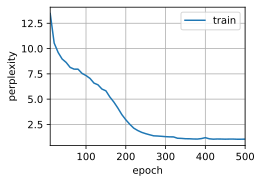

In [ ]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

**使用随机抽样方法的结果**

困惑度 1.5, 15249.9 词元/秒 cpu
time traveller but now you begin to seethe object of my investig
traveller after the pauserequired for the proper assimilati


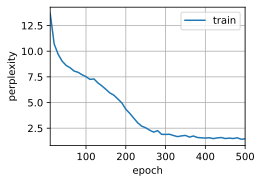

In [ ]:
net = RNNModelScratch(
  len(vocab), num_hiddens, d2l.try_gpu(), get_params,
  init_rnn_state, rnn
)
train_ch8(
  net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
  use_random_iter=True
)

## 循环神经网络的简洁实现

In [ ]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

### 定义模型

In [ ]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

**使用张量初始化隐状态**，形状是（隐藏层数，批量大小，隐藏单元数）

In [ ]:
state = torch.zeros((1, batch_size, num_hiddens))  # 从0开始中，是一个tuple
state.shape

torch.Size([1, 32, 256])

**通过一个隐状态和一个输入，可以用更新后的隐状态计算输出**


- `rnn_layer`的输出`Y`不涉及输出层的计算
  - 指的是每个时间步的隐状态，这些隐状态可以用作后续输出层的输入
- `Y`是三维的张量：`(num_steps, batch_size, num_hiddens)`


In [ ]:
X = torch.randn(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

**为完整的循环时间网络模型定义了一个RNNModel类**
- rnn_layer只包含隐藏的循环层，还要创建一个**单独的输出层**

- `nn.RNN`有
  - 属性`hidden_size`，表示RNN模块中隐藏层状态的维度
  - 属性`bidirecitonal`是一个布尔值，表示RNN模块是否为双向RNN

**begin_state到底是什么含义？？还未看到**

In [ ]:
class RNNModel(nn.Module):
  def __init__(self, rnn_layer, vocab_size, *kwargs):
    super().__init__()
    self.rnn = rnn_layer
    self.vocab_size = vocab_size
    self.num_hiddens = self.rnn.hidden_size
    # 如果RNN是双向的，num_directions应该是2，否则是1
    if not self.rnn.bidirectional:
      self.num_directions = 1
      self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
    else:
      self.num_hiddens = 2
      self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

  def forward(self, inputs, state):
    X = F.one_hot(inputs.T.long(), self.vocab_size)
    X = X.to(torch.float32)
    # Y的形状是(时间步数，批量大小，隐藏单元数)
    Y, state = self.rnn(X, state)  #不太对吧# inputs(X)的形状(seq_len, batch_size, vocab_size)
    # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
    # 它的输出形状是(时间步数*批量大小,词表大小)
    output = self.linear(Y.reshape(-1, Y.shape[-1]))
    return output, state

  def begin_state(self, device, batch_size=1):
    if not isinstance(self.rnn, nn.LSTM):
      # nn.GRU以张量作为隐状态
      return torch.zeros((
        self.num_directions * self.rnn.num_layers,
        batch_size, self.num_hiddens
        ), device=device
      )
    else:
      # nn.LSTM以元组作为隐状态
      return (
        torch.zeros((
          self.num_directions * self.rnn.num_layers,
          batch_size, self.num_hiddens
          ), device=device
        ),
        torch.zeros((
          self.num_directions * self.rnn.num_layers,
          batch_size, self.num_hiddens
          ), device=device)
        )

### 训练与预测

**先基于一个随机权重进行预测**

In [ ]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
predict_ch8('time traveller', 10, net, vocab, device)

'time travellerkbbbbbbbbb'

困惑度 1.3, 51764.7 词元/秒 cpu
time traveller proceededintinn aid the medical man andfilbythatt
travellerid to ot atous t move about in time for instance i


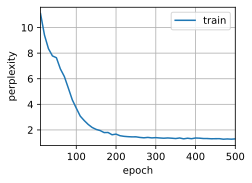

In [ ]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

## 注意：
**RNN有点像MLP**，做不了很长的序列（100以内），否则很容易overfitting

## 小结

RNN
- 对**隐状态**使用循环计算的神经网络成为RNN
- 循环神经网络的隐状态可以捕获**直到当前时间步**序列的历史信息
- 循环神经网络模型的**参数数量**不会随着时间步的增加而增加
- 可以使用循神经网络**创建字符级语言模型**
- 可以使用**困惑度**来评价语言模型的质量

从0开始实现
- 可以训练一个**基于循环神经网络的字符级**语言模型，根据用户提供的文本的前缀生成后续文本
- 一个简单的循环神经网络语言模型包括**输入编码**、**循环时间网络模型**和**输出**
- 循环神经网络模型在训练以前需要初始化状态，不过随机抽样和顺序划分使用初始化方法**不同**
- 当使用顺序划分时，需要**分离梯度**以减少计算量
- 在进行任何预测之前，模型通过**预热期**进行自我更新
- **梯度裁剪**可以**防止梯度爆炸**，但不能应对梯度消失

简洁实现
- 高级API的循环神经网络层返回一个输出和一个更新后的隐状态，**还需要**计算整个模型的**输出层**
- 相比从0开始实现的循环神经网络，使用高级API实现可以加速训练

## 训练

### RNN

#### 1
1. 使用循环神经网络来预测文本序列中的下一个字符，那么任意输出所需的维度是多少？
- 在循环神经网络中，当前时间步计算得到的隐藏层
  - 一方面会作为下一时间步的输入
  - 另一方面会输入到全连接层中用于计算当前时间步的输出


In [ ]:
!pip install d2l

In [ ]:
import torch
import numpy as np

from d2l import torch as d2l
from torch import nn
from torch.nn import functional as F

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [ ]:
X = torch.arange(10).reshape(2, 5)
F.one_hot(X.T, len(vocab)).shape

torch.Size([5, 2, 28])

In [ ]:
# 初始化参数和RNN模型

def get_params(vocab_size, num_hiddens, device):
  num_inputs = num_outputs = vocab_size

  def normal(size):
    return torch.randn(size, device=device) * 0.01

  W_xh = normal((num_inputs, num_hiddens))
  W_hh = normal((num_hiddens, num_hiddens))
  b_h = torch.zeros(num_hiddens, device=device)
  W_hq = normal((num_hiddens, num_outputs))
  b_q = torch.zeros(num_outputs, device=device)
  params = [W_xh, W_hh, b_h, W_hq, b_q]
  for param in params:
    param.requires_grad_(True)
  return params

def init_rnn_state(batch_size, num_hiddens, device):
  return (torch.zeros((batch_size, num_hiddens), device=device),)

def rnn(inputs, state, params):
  # inputs的形状(时间步长度，批量大小，词表大小)
  W_xh, W_hh, b_h, W_hq, b_q = params
  H, = state
  outputs = []
  for X in inputs:
    H = torch.tanh(torch.mm(H, W_hh) + torch.mm(X, W_xh) + b_h)
    Y = torch.mm(H, W_hq) + b_q
    outputs.append(Y)
  # 看看形状
  # Y_list = torch.stack(outputs)
  # print('Y_list.shape:', Y_list.shape)
  return torch.cat(outputs, dim=0), (H,)

class RNNModelScratch:
  # 从0开始实现的循环神经网络
  def __init__(
    self, vocab_size, num_hiddens, device,
    get_params, init_state, forward_fn
  ):
    self.vocab_size = vocab_size
    self.num_hiddens = num_hiddens
    self.params = get_params(vocab_size, num_hiddens, device)
    self.init_state = init_state
    self.forward_fn = forward_fn

  def __call__(self, X, state):
    X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
    # 打印转换后的X的维度
    # print('X.shape:', X.shape)
    return self.forward_fn(X, state, self.params)

  def begin_state(self, batch_size, device):
    return self.init_state(batch_size, self.num_hiddens, device)

In [ ]:
num_hiddens = 256
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
print('state.shape:', new_state[0].shape)

state.shape: torch.Size([2, 256])


#### 2、3、4

2. 为什么循环神经网络可以基于文本序列中所有先前的词元，在某个时间步表示当前词元的条件概率？
- 答
  - 因为语言模型的目标是根据过去和当前的词元来预测出下一个词元，在循环神经网络中，通过引入隐状态的概念，使得RNN模型可以通过隐状态保留了直到当前时间步的历史信息，根据这些过去历史信息，循环神经网络可以预测出当前词元的生成

3. 如果基于一个长序列进行反向传播，梯度会发生什么状况？
- 答
  - 基于长序列进行反向传播时，假设序列长度为
$T$，则迭代计算T个时间步的梯度时，会产生长度为
$O(T)$的矩阵乘法链，造成**类似多层感知机中层数为
$T$的情况**，因此当序列长度过长时，会使得梯度值在反向传播进行梯度累乘时放大或缩小梯度值，导致数值不稳定，出现梯度爆炸或者梯度消失等现象。

4. 与本节中描述的语言模型相关的问题有哪些？
- 循环神经网络常被用来处理序列问题，具体应用场景如下：
  - 文本生成
  - 文本分类
  - 机器翻译

### RNN的从0开始实现

#### 1
1. 尝试说明独热编码等价于为每个对象选择不同的嵌入表示
- 答
  - one-hot编码可以将词表中的每个单词编码为一个独立符号，使得任何词在与词表同样大小的one-hot向量中都具有一个独一无二的维度，实现对不同词的不同嵌入表示（稀疏）
  - 嵌入表示是对类别的一种**低维稠密向量**表示，通过学习使向量能够捕捉类别之间的潜在关系
  - 等价关系
    - one-hot可以看作一种特殊形式的嵌入表示
  - 独热编码等价于为每个对象选择不同的嵌入表示，只是嵌入的维度等于类别数量，并且没有经过任务特定的优化
  - 而嵌入表示通过学习调整向量分布，使其在低维空间中有效表达类别之间的潜在关系

#### 2
2. 通过调整超参数（如迭代周期数、隐藏单元数、小批量数据的时间步数、学习率等）来改善困惑度
- 困惑度可以降到多少（取值范围就是0-正无穷）
- 用可学习的嵌入表示替换独热编码，是否会带来更好的表现？
- 如果用H.G.Wells的其他书作为数据集时效果如何，例如世界大战？

In [ ]:
# [迭代周期，隐藏单元数，批量大小，小批量数据时间步数，学习率]

hyper_1 = [256, 512, 35, 10, 1]
hyper_2 = [500, 512, 35, 32, 1]
hyper_3 = [500, 128, 10, 10, 1]
hyper_4 = [1000, 256, 10, 32, 0.01]
hyper_params = [hyper_1, hyper_2, hyper_3, hyper_4]

In [ ]:
def clipping_grad(net, theta):
  if isinstance(net, nn.Module):
    params = [p for p in net.parameters() if p.requires_grad]
  else:
    params = net.params
  norm = torch.sqrt(sum(torch.sum(p.grad ** 2) for p in params))
  if norm > theta:
    for param in params:
      param.grad[:] *= (theta / norm)


def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
  state, timer = None, d2l.Timer()
  metric = d2l.Accumulator(2)
  for X, Y in train_iter:
    if state is None or use_random_iter:
      state = net.begin_state(batch_size=X.shape[0], device=device)  # 不写清楚的话，位置对应不上！！！
    else:
      if isinstance(net, nn.Module) and not isinstance(state, tuple):
        state.detach_()
      else:
        for s in state:
          s.detach_()
    y = Y.T.reshape(-1) # 将时间放到第一维，拉成一个向量
    X, y = X.to(device), y.to(device)
    y_hat, state = net(X, state)
    l = loss(y_hat, y.long()).mean()
    if isinstance(updater, torch.optim.Optimizer):
      updater.zero_grad()
      l.backward()
      clipping_grad(net, 1)
      updater.step()
    else:
      l.backward()
      clipping_grad(net, 1)
      updater(batch_size=1)
    metric.add(l * y.numel(), y.numel())
  # 计算困惑度
  return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def predict_ch8(prefix, num_preds, net, vocab, device):
  state = net.begin_state(batch_size=1, device=device)
  outputs = [vocab[prefix[0]]]
  get_inputs = lambda: torch.tensor(outputs[-1], device=device).reshape(-1, 1)  # 变成2维tensor
  # 预热期
  for y in prefix[1:]:
    _, state = net(get_inputs(), state)
    outputs.append(vocab[y])
  for _ in range(num_preds):
    y, state = net(get_inputs(), state)
    outputs.append(int(y.argmax(dim=1).reshape(1)))
  return ''.join([vocab.idx_to_token[i] for i in outputs])  # 转化为token

In [ ]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
               legend=['train'], xlim=[10, num_epochs])
  if isinstance(net, nn.Module):
    updater = torch.optim.SGD(net.parameters(), lr)
  else:
    # 自定义函数，参数是batch_size
    updater = lambda batch_size:d2l.sgd(net.params, lr, batch_size)
  predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
  for epoch in range(num_epochs):
    ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
    if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
  print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
  return ppl

- `round(number, ndigits)`对数字进行四舍五入
  - `ndigits`要保留的小数位数
    - 省略：返回整数
    - 负数：向左（整数部分）进行四舍五入

In [ ]:
perplexity = []
for i in range(len(hyper_params)):
  num_epochs, num_hiddens, batch_size, num_steps, lr = hyper_params[i]
  train_iter, vocab = load_data_time_machine(batch_size, num_steps)
  net = RNNModelScratch(
    len(vocab), num_hiddens, d2l.try_gpu(),
    get_params, init_rnn_state, rnn
  )
  value = train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())
  perplexity.append(value)
  print('hyper[%d]:%.1f'%(i,perplexity[i]))

hyper[0]:1.5
hyper[1]:1.0
hyper[2]:18.4
hyper[3]:8.9


采用可学习嵌入表示来替换one-hot会带来更好的表现
- 因为可学习的嵌入表示可以将相似近义词映射到相似嵌入向量中
  - 可以使得语义信息得到更好的表示
- 而不是one-hot中相互独立的向量基

- `RuntimeError: Cannot access accelerator device when none is available`
  - 原因：参数位置没有对应好

困惑度 1.7, 61509.6 词元/秒 cpu


1.691694999430932

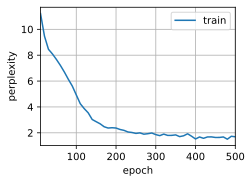

In [ ]:
# one-hot编码

class RNNModel(nn.Module):
  def __init__(self, vocab_size, rnn_layer, *kwargs):
    super().__init__()
    self.rnn = rnn_layer
    self.vocab_size = vocab_size
    self.num_hiddens = self.rnn.hidden_size
    if not self.rnn.bidirectional:
      self.num_directions = 1
      self.linear = nn.Linear(num_hiddens, self.vocab_size)
    else:
      self.num_directions = 2
      self.linear = nn.Linear(num_hiddens * 2, self.vocab_size)

  def forward(self, X, state):
    X = F.one_hot(X.T, self.vocab_size)
    X = X.to(torch.float32)
    Y, state = self.rnn(X)  # Y的形状（时间步数，批量大小，隐藏单元数）
    output = self.linear(Y.reshape(-1, self.num_hiddens))  # 输出的大小(时间步数*批量大小，词表大小)
    return output, state


  def begin_state(self, device, batch_size=1):
    if not isinstance(self.rnn, nn.LSTM):
      # nn.GRU以张量作为隐状态
      return torch.zeros(
        (self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens),
        device=device
      )
    else:
      # nn.LSTM以元组作为隐状态
      return (torch.zeros((
          self.num_directions * self.rnn.num_layers,
          batch_size, self.num_hiddens), device=device),
              torch.zeros((
                  self.num_directions * self.rnn.num_layers,
                  batch_size, self.num_hiddens), device=device))

num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)
device = d2l.try_gpu()
print(device)
net = RNNModel(len(vocab), rnn_layer)
net = net.to(device)
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

**可学习嵌入表示**
- 如果`embedding_dims`不再是`vocab_size`大小的话，**train_iter需要发生变化！！！**

**`nn.Embedding(num_embeddings, embedding_dims)`**
  - `num_embeddings`词汇表大小（即可嵌入的总数）
- 输入：接受一个任意形状的整数张量，这些整数表示离散的索引，如`(batch_size, sequence_length)`
- 输出：形状相同的嵌入张量，每个索引被映射为一个`embedding_dim`大小的张量，即`(batch_size, sequence_length, embedding_dim)`

困惑度 1.0, 57975.2 词元/秒 cpu


1.0294256524340517

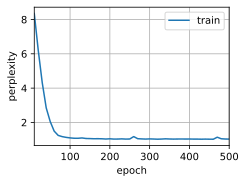

In [ ]:
class RNNModel_Embedding(nn.Module):
  def __init__(self, rnn_layer, vocab_size, embedding_dim, **kwargs):
    super().__init__()
    self.rnn = rnn_layer
    self.vocab_size = vocab_size
    self.num_hiddens = self.rnn.hidden_size
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    if not self.rnn.bidirectional:
      self.num_directions = 1
      self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
    else:
      self.num_directions = 2
      self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

  def forward(self, inputs, state):
    X = self.embedding(inputs.T.long())
    X = X.to(torch.float32)
    Y, state = self.rnn(X, state)
    output = self.linear((Y.reshape(-1, Y.shape[-1])))
    return output, state

  def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))


num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)
device = d2l.try_gpu()
embedding_dim = 28
net = RNNModel_Embedding(rnn_layer, vocab_size=len(vocab), embedding_dim=embedding_dim)
net.to(device)
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device)